In [2]:
import csv
import json
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
from glob import glob

import warnings
warnings.filterwarnings('ignore')

output_path = 'deeptest_plots/'

In [3]:
# Keep this if run inside scripts folder - sets cwd to the right parent folder
if os.path.basename(os.getcwd()) == "scripts":
    parent_of_data_reader = str(Path('../').absolute())
    sys.path.insert(0, parent_of_data_reader)
    os.chdir(parent_of_data_reader)

run_numbers = 6

datasets = ['gtsrb']#, 'imagenette', 'imagewoof']
models = ['vgg16_fine_tuning']
epoch = 29

# datasets = ['rsna_small']
# models = ['densenet121_no_weights']
# epoch = 30


result_paths = []
for dataset in datasets:
    for model in models:
        for run_num in range(run_numbers):
            base_output_path = Path(os.getcwd() + '/outputs/' + dataset + '/' + model + f'_run{run_num}/' + f'epoch{epoch}/' + 'targets/')
            result_paths.extend(list(base_output_path.rglob('*test_class_metrics.txt')))

data_dict = {}
for path in result_paths:
    new_text = []
#     name = str(path).split('/')[6:-1]
    print(path)
    with open(str(path),'r') as f:
        text = f.readlines()
        for line in text:
            new_text.append(line.strip('\n'))
        
    print(new_text)
    # Concatenate the lines again
    text = ''
    for line in new_text:
        text += line
    
    print(f'new text file: {text}')
    with open(str(path), 'w') as f:
        f.write(text)
    
    with open(str(path)) as f:
        data = json.load(f)
        data_dict[str(path)[41:]] = data


# Create a list of dicts from dict if dicts
csv_list = []
for key, value_dict in data_dict.items():
    if '10x' in key:
        continue
    new_dict = {'path':key}
    for metric, val in value_dict.items():
        if metric == 'per_class_accuracy':
            for i, class_acc in enumerate(value_dict[metric]):
                new_key = f'cls_acc_{i}'
                new_dict[new_key] = class_acc
        else:
            new_dict[metric]=val
    print(new_dict)
    csv_list.append(new_dict)

import pandas as pd
df = pd.DataFrame(csv_list)
# df.to_csv('my_file.csv', index=False, header=True)

def calc_common_accuracy(total_acc, cls_acc, alpha=0.):
    '''
    Function to calculate a weighted common metric between total accuracy and class specific accuracy
    alpha : how much weight we put onto 
    
    :Returns:
    float: weighted accuracy
    '''
#     print(alpha)
    if alpha < 0.0 or alpha > 1.0:
        raise ValueError(f'Alpha is not inside the expected value range')
    
    return ((1-alpha) * total_acc) + (alpha * cls_acc)


df['dataset'] = df.apply(lambda x: str(x['path']).split('/')[0], axis=1)

df['model'] = df.apply(lambda x: str(x['path']).split('/')[1][:-5], axis=1)

df['epoch'] = df.apply(lambda x: int(str(x['path']).split('/')[2].replace('epoch','')), axis=1)

df['run'] = df.apply(lambda x: int(str(x['path']).split('/')[1][-1:]), axis=1)

df['repaired'] = df.apply(lambda x: True if 'negative' in str(x['path']) else False, axis=1)

df['epoch_ep'] = df.apply(lambda x: int(str(x['path']).split('/')[4].replace('ep','')), axis=1)

df['rep_cls'] = df.apply(lambda x: int(str(x['path']).split('/')[6]) if x['repaired'] == True else None, axis=1)

df['more_finetune'] = df.apply(lambda x: True if ('fine_tune' in (str(x['path']).split('/')[-2]) and x['repaired'] == False) else False, axis = 1)

# df['more_finetune'] = df.apply(lambda x: print('fine_tune' in str(x['path']).split('/')[-2]), axis = 1)

df['more_finetune_epochs'] = df.apply(lambda x: int((str(x['path']).split('/')[-2]).split('_')[2]) if x['more_finetune'] == True else None, axis=1)

df['more_finetune_emphasis_class'] = df.apply(lambda x: int((str(x['path']).split('/')[-2]).split('_')[-1]) if x['more_finetune'] == True else None, axis=1)
                               
rep_classes = df['rep_cls'].unique()
# If there is only none, skip
if len(rep_classes) != 1:
    for rep_cls in rep_classes:
        if rep_cls is None or np.isnan(rep_cls):
            # skip for non_repaired
            continue
        for i in range(10):
            df[f'common_metric_{i+1}0_cls{int(rep_cls)}'] = df.apply(lambda x: calc_common_accuracy(x['accuracy'], x[f'cls_acc_{int(rep_cls)}'], alpha=0.1*(i+1)), axis=1)


/home/amancu/projects/eAI-Repair/outputs/gtsrb/vgg16_fine_tuning_run0/epoch29/targets/ep05/ep05test_class_metrics.txt
['{"per_class_accuracy": [0.8833333333333333, 0.9722607489597781, 0.932, 0.9844444444444445, 0.9409090909090909, 0.6968253968253968, 0.9, 0.8711111111111111, 0.9333333333333333, 0.98125, 0.9636363636363636, 0.930952380952381, 0.9956521739130435, 0.9986111111111111, 0.9703703703703703, 0.9952380952380953, 0.9933774834437086, 0.95, 0.8564102564102564, 0.8, 0.9, 0.6666666666666666, 0.7833333333333333, 0.7666666666666667, 0.9666666666666667, 0.9166666666666666, 0.9111111111111111, 0.55, 0.9333333333333333, 0.9777777777777777, 0.6466666666666666, 0.9222222222222223, 1.0, 0.9571428571428572, 0.9166666666666666, 0.9615384615384616, 0.9833333333333333, 0.9833333333333333, 0.936231884057971, 0.9444444444444444, 0.9111111111111111, 0.9833333333333333, 0.9444444444444444], "accuracy": 0.9246358454718177, "f1": 0.9007752943749245, "recall": 0.9072652715002065, "auc_under_roc": 0.99

In [194]:
df[df['repaired']==True][df['rep_cls']==1.0][['path','run','epoch','epoch_ep', 'rep_cls']+ [f'cls_acc_{i}' for i in range(2)]].sort_values('epoch')

,path,run,epoch,epoch_ep,rep_cls,cls_acc_0,cls_acc_1
1,rsna_small/densenet121_no_weights_run0/epoch30/targets/ep05/negative/1/repaired_model_0/repair/test_class_metrics.txt,0,30,5,1.0,0.825604,0.591362
35,rsna_small/densenet121_no_weights_run4/epoch30/targets/ep01/negative/1/repaired_model_0/repair/test_class_metrics.txt,4,30,1,1.0,1.000000,0.000000
33,rsna_small/densenet121_no_weights_run4/epoch30/targets/ep05/negative/1/repaired_model_0/repair/test_class_metrics.txt,4,30,5,1.0,0.619807,0.873754
31,rsna_small/densenet121_no_weights_run3/epoch30/targets/ep10/negative/1/repaired_model_0/repair/test_class_metrics.txt,3,30,10,1.0,0.795652,0.740864
29,rsna_small/densenet121_no_weights_run3/epoch30/targets/ep13/negative/1/repaired_model_0/repair/test_class_metrics.txt,3,30,13,1.0,0.565700,0.925249
27,rsna_small/densenet121_no_weights_run3/epoch30/targets/ep01/negative/1/repaired_model_0/repair/test_class_metrics.txt,3,30,1,1.0,0.001449,1.000000
25,rsna_small/densenet121_no_weights_run3/epoch30/targets/ep05/negative/1/repaired_model_0/repair/test_class_metrics.txt,3,30,5,1.0,0.767633,0.752492
23,rsna_small/densenet121_no_weights_run2/epoch30/targets/ep10/negative/1/repaired_model_0/repair/test_class_metrics.txt,2,30,10,1.0,0.828986,0.684385
21,rsna_small/densenet121_no_weights_run2/epoch30/targets/ep15/negative/1/repaired_model_0/repair/test_class_metrics.txt,2,30,15,1.0,0.673430,0.822259
19,rsna_small/densenet121_no_weights_run2/epoch30/targets/ep16/negative/1/repaired_model_0/repair/test_class_metrics.txt,2,30,16,1.0,0.670531,0.837209


In [117]:
df[df['repaired']==False][df['run']==4][['path'] + [f'cls_acc_{i}' for i in range(1)]]

/home/amancu/mambaforge/envs/exp2/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,path,cls_acc_0
30,rsna_small/densenet121_no_weights_run4/epoch30/targets/ep05/test_class_metrics.txt,0.926087
32,rsna_small/densenet121_no_weights_run4/epoch30/targets/ep01/test_class_metrics.txt,0.999517
34,rsna_small/densenet121_no_weights_run4/epoch30/targets/ep11/test_class_metrics.txt,0.922222
36,rsna_small/densenet121_no_weights_run4/epoch30/targets/ep10/test_class_metrics.txt,0.877778


## Patterns

### RSNA

-------------------- run 0 -----------------------------
total base: [0.77881737 0.81586826 0.83158683 0.83495509], rep [0.22642216 0.77282934 0.79416168 0.80351796]
class base: [0.03654485 0.31727575 0.4551495  0.54318937], rep [1.         0.59136213 0.69601329 0.70431894]
-------------------- run 1 -----------------------------
total base: [0.79565868 0.81474551 0.80202096], rep [0.3248503  0.78443114 0.71706587]
class base: [0.2641196  0.54318937 0.59800664], rep [0.96843854 0.74086379 0.7923588 ]
-------------------- run 2 -----------------------------
total base: [0.8001497  0.81624251 0.82110778 0.83158683 0.83158683], rep [0.22754491 0.79565868 0.79640719 0.70696108 0.70808383]
class base: [0.25415282 0.48671096 0.49667774 0.52990033 0.52990033], rep [1.         0.60797342 0.68438538 0.82225914 0.8372093 ]
-------------------- run 3 -----------------------------
total base: [0.78555389 0.79116766 0.80351796 0.81998503], rep [0.22642216 0.76422156 0.78330838 0.64670659]
class bas

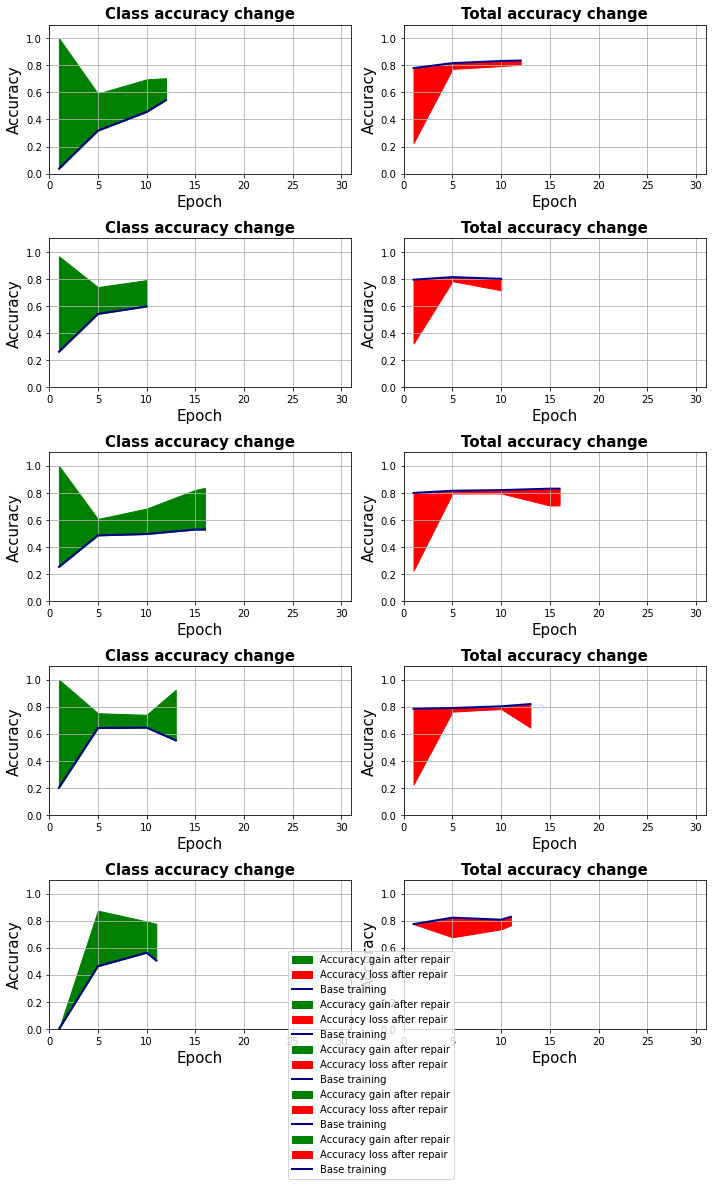

In [195]:
### Total Accuracy

rep_classes = [1.0]
colors = {10:'red', 20:'green', 30:'blue', 40:'cyan', 50:'purple', 60:'orange' , 70:'#d62728', 80:'#d67728', 90:'#e62728',100:'#d61228'}
epochs = [key for key in colors.keys()]
col = [val for k,val in colors.items()]

fig, ax = plt.subplots(5,2,figsize=(10,15),)

for j, run in enumerate(df['run'].unique()):
    print(f'-------------------- run {run} -----------------------------')
    base_table = df[df['repaired']==False][df['more_finetune']==False][df['run']==run]
    rep_table = df[df['repaired']==True][df['run']==run]
    for i, rep_cls in enumerate(rep_classes):
        # Total accuracy
            
        cur_rep_table = rep_table[rep_table['rep_cls'] == rep_cls].sort_values('epoch_ep')['accuracy']
        np_cur_rep_table = np.array(cur_rep_table)

        # Eliminate epochs where we do not have a repair
        epocks = rep_table[rep_table['rep_cls'] == rep_cls].sort_values('epoch_ep')['epoch_ep'].unique()

        cur_base_table = base_table[base_table['epoch_ep'].isin(epocks)].sort_values('epoch_ep')[f'accuracy']
        np_cur_base_table = np.array(cur_base_table)

        print(f'total base: {np_cur_base_table}, rep {np_cur_rep_table}')


        ax[run][1].fill_between(epocks\
                                , cur_base_table, cur_rep_table\
                                , where= np_cur_base_table <= np_cur_rep_table, interpolate=True, color='green'\
                                , label=f'Accuracy gain after repair')
        ax[run][1].fill_between(epocks\
                                , cur_base_table, cur_rep_table\
                                , where= np_cur_base_table >= np_cur_rep_table, interpolate=True, color='red'\
                                , label=f'Accuracy loss after repair')

        ax[run][1].plot(epocks, np_cur_base_table, color='darkblue', linewidth=2, label=f'Base training')
        
        ax[run][1].grid(True)
        ax[run][1].set_xlim(0,31.0)
        ax[run][1].set_ylim(0,1.1)
        ax[run][1].set_xlabel('Epoch', size=15)
        ax[run][1].set_ylabel(f'Accuracy', size=15)
        ax[run][1].set_title(f'Total accuracy change', fontweight="bold", size=15)
        
        # Class specific accuracy
        cur_rep_table = rep_table[rep_table['rep_cls'] == rep_cls].sort_values('epoch_ep')[f'cls_acc_{int(rep_cls)}']
        np_cur_rep_table = np.array(cur_rep_table)

        # Eliminate epochs where we do not have a repair
        epocks = rep_table[rep_table['rep_cls'] == rep_cls].sort_values('epoch_ep')['epoch_ep'].unique()

        cur_base_table = base_table[base_table['epoch_ep'].isin(epocks)].sort_values('epoch_ep')[f'cls_acc_{int(rep_cls)}']
        np_cur_base_table = np.array(cur_base_table)

        print(f'class base: {np_cur_base_table}, rep {np_cur_rep_table}')

        ax[run][0].fill_between(epocks\
                                , cur_base_table, cur_rep_table\
                                , where= np_cur_base_table <= np_cur_rep_table, interpolate=True, color='green')
        ax[run][0].fill_between(epocks\
                                , cur_base_table, cur_rep_table\
                                , where= np_cur_base_table >= np_cur_rep_table, interpolate=True, color='red')

        ax[run][0].plot(epocks, np_cur_base_table, color='darkblue', linewidth=2)
        
        ax[run][0].grid(True)
        ax[run][0].set_xlim(0,31.0)
        ax[run][0].set_ylim(0,1.1)
        ax[run][0].set_xlabel('Epoch', size=15)
        ax[run][0].set_ylabel(f'Accuracy', size=15)
        ax[run][0].set_title(f'Class accuracy change', fontweight="bold", size=15)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.52, -0.1))
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.28))
plt.grid(True)
fig.tight_layout()
# fig.subplots_adjust(bottom=0.5)
plt.show()

In [ ]:
base_table = df[df['repaired']==False][df['more_finetune']==False][df['run']==3]
rep_table = df[df['repaired']==True][df['run']==3]

In [ ]:
cur_rep_table = rep_table[rep_table['rep_cls'] == rep_cls].sort_values('epoch').groupby('epoch').mean()['accuracy']
np_cur_rep_table = np.array(cur_rep_table)

# Eliminate epochs where we do not have a repair
epocks = rep_table[rep_table['rep_cls'] == rep_cls].sort_values('epoch')['epoch'].unique()

cur_base_table = base_table[base_table['epoch'].isin(epocks)].groupby('epoch')[f'accuracy'].mean()
np_cur_base_table = np.array(cur_base_table)

print(np_cur_rep_table)
print(np_cur_base_table)

In [ ]:
# Class specific accuracy
cur_rep_table = rep_table[rep_table['rep_cls'] == rep_cls].sort_values('epoch').groupby('epoch').mean()[f'cls_acc_{int(rep_cls)}']
np_cur_rep_table = np.array(cur_rep_table)

# Eliminate epochs where we do not have a repair
epocks = rep_table[rep_table['rep_cls'] == rep_cls].sort_values('epoch')['epoch'].unique()

cur_base_table = base_table[base_table['epoch'].isin(epocks)].groupby('epoch')[f'cls_acc_{int(rep_cls)}'].mean()
np_cur_base_table = np.array(cur_base_table)

print(np_cur_rep_table)
print(np_cur_base_table)

### Common Metric

Score: 20--------------------------
Class 1.0:
[(1, 5    0.381138
Name: common_metric_20_cls1, dtype: float64), (5, 1    0.736536
Name: common_metric_20_cls1, dtype: float64), (10, 7    0.774532
Name: common_metric_20_cls1, dtype: float64), (12, 3    0.783678
Name: common_metric_20_cls1, dtype: float64)]
Score: 50--------------------------
Class 1.0:
[(1, 5    0.613211
Name: common_metric_50_cls1, dtype: float64), (5, 1    0.682096
Name: common_metric_50_cls1, dtype: float64), (10, 7    0.745087
Name: common_metric_50_cls1, dtype: float64), (12, 3    0.753918
Name: common_metric_50_cls1, dtype: float64)]
Score: 80--------------------------
Class 1.0:
[(1, 5    0.845284
Name: common_metric_80_cls1, dtype: float64), (5, 1    0.627656
Name: common_metric_80_cls1, dtype: float64), (10, 7    0.715643
Name: common_metric_80_cls1, dtype: float64), (12, 3    0.724159
Name: common_metric_80_cls1, dtype: float64)]
Score: 20--------------------------
Class 1.0:
[(1, 11    0.453568
Name: common_me

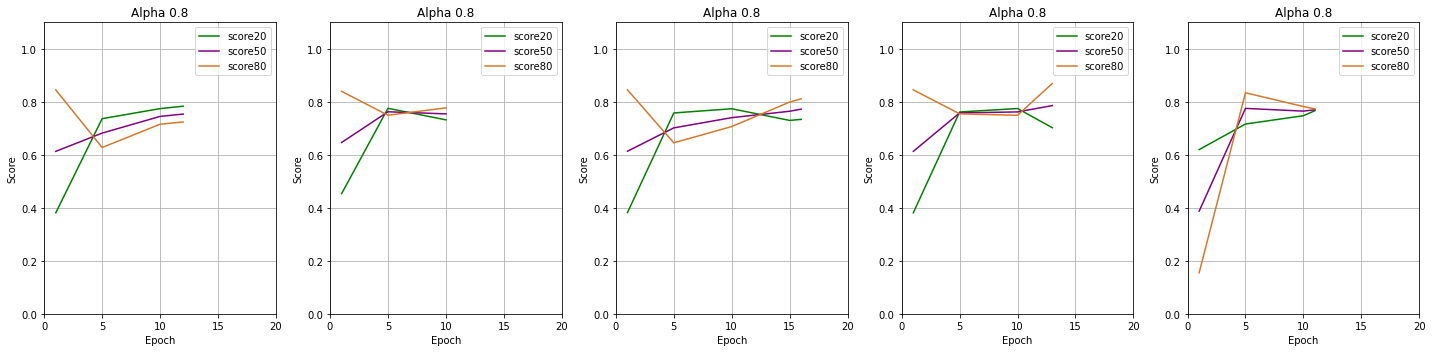

In [203]:
colors = {10:'red', 20:'green', 30:'blue', 40:'cyan', 50:'purple', 60:'orange' , 70:'#d62728', 80:'#d67728', 90:'#e62728',100:'#d61228'}
epochs = [key for key in colors.keys()]
col = [val for k,val in colors.items()]

rep_classes = [1.0]
scores = [20,50,80]

fig, ax = plt.subplots(1,5,figsize=(20,5))

for i in df['run'].unique():
    for score in scores:
        print(f'Score: {score}--------------------------')
        print(f'Class {rep_cls}:')
        base_table = df[df['repaired']==False][df['more_finetune']==False][df['run']==run]
        rep_table = df[df['repaired']==True][df['run']==i]

        ax[i%5].plot(rep_table.sort_values('epoch_ep')['epoch_ep'].unique()\
                                    ,rep_table.sort_values('epoch_ep')[f'common_metric_{score}_cls{int(1.0)}'], c=colors[score], label=f'score{score}')

        print(list(rep_table.sort_values('epoch_ep').groupby('epoch_ep')[f'common_metric_{score}_cls{int(1.0)}']))

        ax[i%5].legend(loc="best")
        ax[i%5].grid(True)
        ax[i%5].set_xlim(0,20.0)
        ax[i%5].set_ylim(0,1.1)
        ax[i%5].set_xlabel('Epoch')
        ax[i%5].set_ylabel(f'Score')
        ax[i%5].set_title(f'Alpha {score*0.01:.1f}')

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
fig.tight_layout()
plt.show()

In [199]:
colors = {10:'red', 20:'green', 30:'blue', 40:'cyan', 50:'purple', 60:'orange' , 70:'#d62728', 80:'#d67728', 90:'#e62728',100:'#d61228'}
epochs = [key for key in colors.keys()]
col = [val for k,val in colors.items()]

rep_classes = [1.]
scores = [20,50,80]

case1 = 0
case2 = 0

for score in scores:
    print(f'Score: {score}--------------------------')

    for i in df['run'].unique():
        print(f'-------------------- run {i} -----------------------------')
        run_epochs = df[df['repaired']==True][df['run']==i].sort_values('epoch_ep')['epoch_ep'].unique()
        # print(run_epochs)
        for j, rep_cls in enumerate(rep_classes):
            print(f'Class {rep_cls}:')
            base_table = df[df['repaired']==False][df['more_finetune']==False][df['run']==run]
            rep_table = df[df['repaired']==True][df['run']==i][df['rep_cls'] == rep_cls]
            run_class_epochs = rep_table.sort_values('epoch_ep')['epoch_ep'].unique()
            print(run_class_epochs, run_epochs)

            try:
                assert np.array_equal(np.array(run_epochs), np.array(run_class_epochs))
            except:
                print('Incomplete repair')
                continue
                # print(f'Exception: {e}')

            # print(rep_table.sort_values('epoch_ep').reset_index(drop=True)\
            #                  [f'common_metric_{score}_cls{int(rep_cls)}'])

            try:
                max_cls = run_epochs[rep_table.sort_values('epoch_ep').reset_index(drop=True)\
                             [f'common_metric_{score}_cls{int(rep_cls)}'].idxmax()]
                print(max_cls)
            except Exception as e:
                print('Incomplete for this class')
                print(f'Exception: {e}')
                continue

            if max_cls == run_class_epochs[-1]:
                case2 += 1
            else:
                case1 +=1

    print(f'Case1: {case1}, case2: {case2}')
    case1 = 0
    case2 = 0

Score: 20--------------------------
-------------------- run 0 -----------------------------
Class 1.0:
[ 1  5 10 12] [ 1  5 10 12]
12
-------------------- run 1 -----------------------------
Class 1.0:
[ 1  5 10] [ 1  5 10]
5
-------------------- run 2 -----------------------------
Class 1.0:
[ 1  5 10 15 16] [ 1  5 10 15 16]
10
-------------------- run 3 -----------------------------
Class 1.0:
[ 1  5 10 13] [ 1  5 10 13]
10
-------------------- run 4 -----------------------------
Class 1.0:
[ 1  5 10 11] [ 1  5 10 11]
11
Case1: 3, case2: 2
Score: 50--------------------------
-------------------- run 0 -----------------------------
Class 1.0:
[ 1  5 10 12] [ 1  5 10 12]
12
-------------------- run 1 -----------------------------
Class 1.0:
[ 1  5 10] [ 1  5 10]
5
-------------------- run 2 -----------------------------
Class 1.0:
[ 1  5 10 15 16] [ 1  5 10 15 16]
16
-------------------- run 3 -----------------------------
Class 1.0:
[ 1  5 10 13] [ 1  5 10 13]
13
--------------------

### GTSRB

-------------------- run 1 -----------------------------
Class 20.0:
total base: [0.85782141 0.93841039 0.94640595 0.94735592 0.94735592], rep [0.85481317 0.93500633 0.94316023 0.94466434 0.94355605]
class base: [0.84444444 0.67777778 0.72222222 0.74444444 0.74444444], rep [0.88888889 0.88888889 0.95555556 0.92222222 0.95555556]
Class 27.0:
total base: [0.85782141 0.93841039 0.94640595 0.94735592 0.94735592], rep [0.85227992 0.93603547 0.94221026 0.94165611 0.9438727 ]
class base: [0.         0.53333333 0.56666667 0.58333333 0.58333333], rep [0.93333333 0.95       0.86666667 0.96666667 0.96666667]
Class 30.0:
total base: [0.85782141 0.93841039 0.94735592 0.94735592], rep [0.83613046 0.93936035 0.9480684  0.94783091]
class base: [0.16       0.56666667 0.62       0.62      ], rep [0.74666667 0.67333333 0.72       0.72      ]
-------------------- run 2 -----------------------------
Class 20.0:
total base: [0.84816339 0.88592464 0.94118113 0.94545598 0.94545598], rep [0.84808423 0.87824573

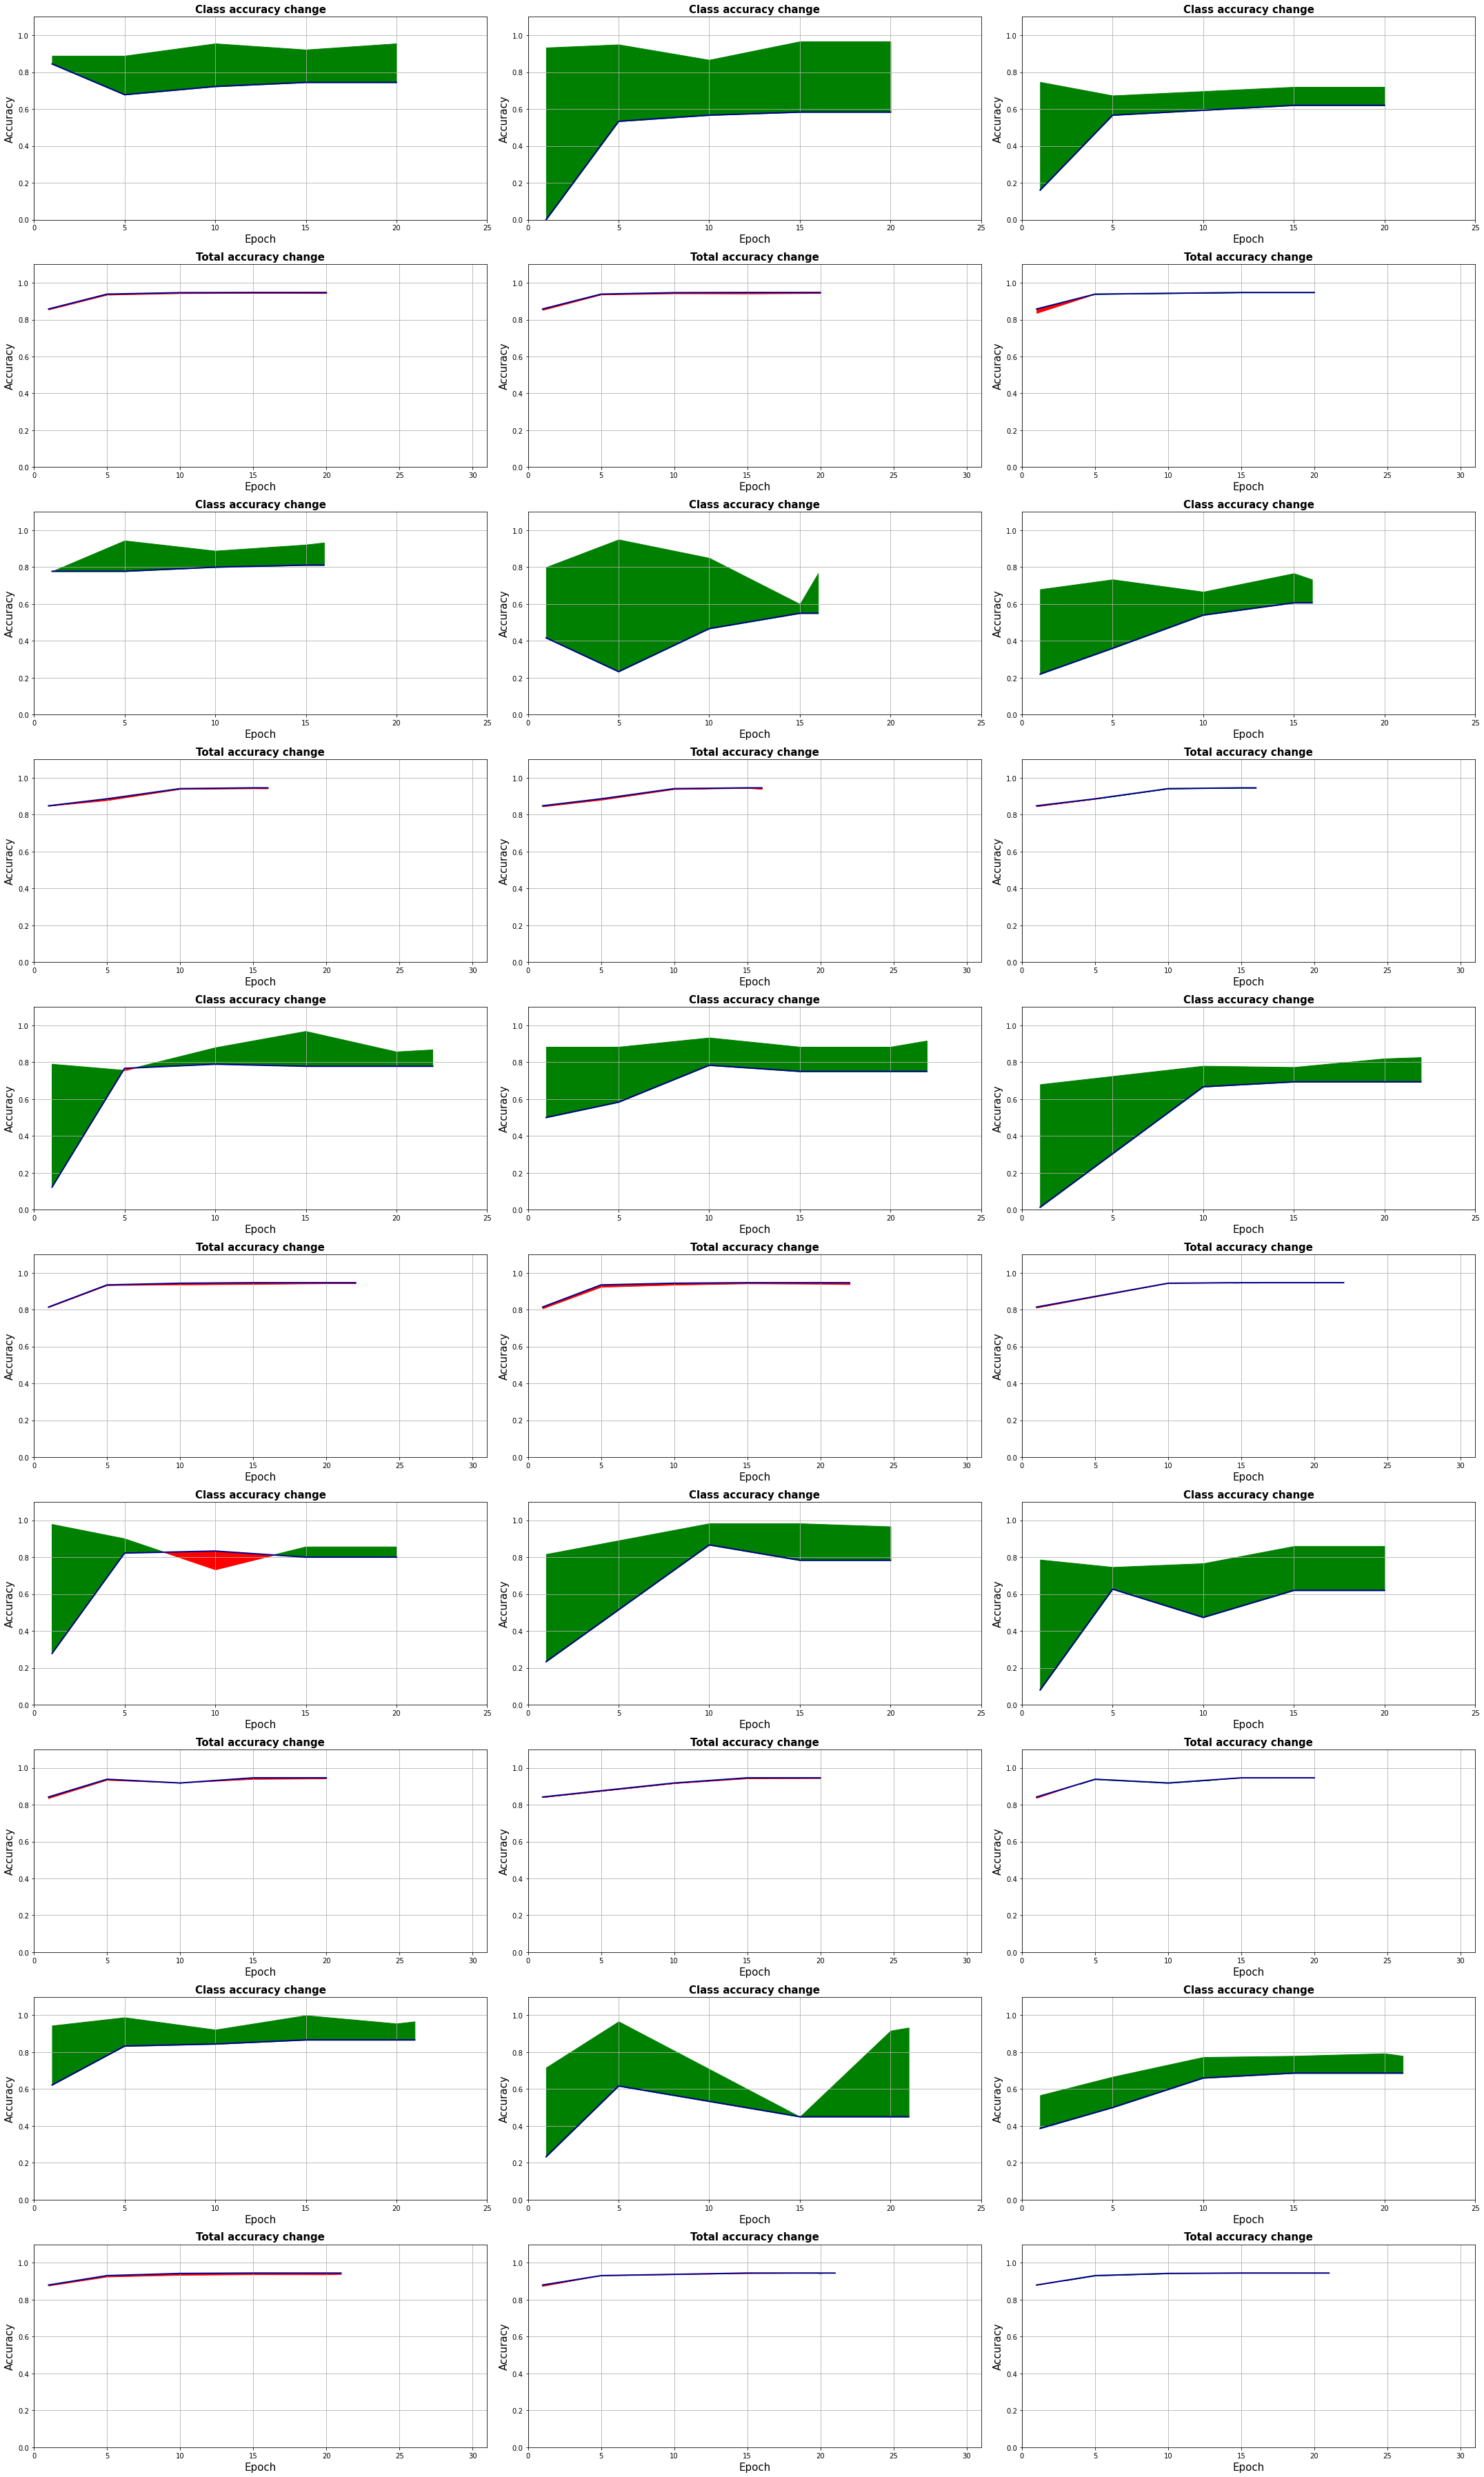

In [9]:
rep_classes = [20., 27., 30.]
colors = {10:'red', 20:'green', 30:'blue', 40:'cyan', 50:'purple', 60:'orange' , 70:'#d62728', 80:'#d67728', 90:'#e62728',100:'#d61228'}
epochs = [key for key in colors.keys()]
col = [val for k,val in colors.items()]

fig, ax = plt.subplots(10,3,figsize=(30,50),)

for run in df['run'].unique()[1:]:
    print(f'-------------------- run {run} -----------------------------')
    base_table = df[df['repaired']==False][df['more_finetune']==False][df['run']==run]
    rep_table = df[df['repaired']==True][df['run']==run]
    for i, rep_cls in enumerate(rep_classes):
        print(f'Class {rep_cls}:')
        # Total accuracy

        cur_rep_table = rep_table[rep_table['rep_cls'] == rep_cls].sort_values('epoch_ep')['accuracy']
        np_cur_rep_table = np.array(cur_rep_table)

        # Eliminate epochs where we do not have a repair
        epocks = rep_table[rep_table['rep_cls'] == rep_cls].sort_values('epoch_ep')['epoch_ep'].unique()

        cur_base_table = base_table[base_table['epoch_ep'].isin(epocks)].sort_values('epoch_ep')[f'accuracy']
        np_cur_base_table = np.array(cur_base_table)

        print(f'total base: {np_cur_base_table}, rep {np_cur_rep_table}')

        ax[(run-1)*2+1][i].fill_between(epocks\
                                , cur_base_table, cur_rep_table\
                                , where= np_cur_base_table <= np_cur_rep_table, interpolate=True, color='green'\
                                , label=f'Accuracy gain after repair')
        ax[(run-1)*2+1][i].fill_between(epocks\
                                , cur_base_table, cur_rep_table\
                                , where= np_cur_base_table >= np_cur_rep_table, interpolate=True, color='red'\
                                , label=f'Accuracy loss after repair')

        ax[(run-1)*2+1][i].plot(epocks, np_cur_base_table, color='darkblue', linewidth=2, label=f'Base training')
        
        ax[(run-1)*2+1][i].grid(True)
        ax[(run-1)*2+1][i].set_xlim(0,31.0)
        ax[(run-1)*2+1][i].set_ylim(0,1.1)
        ax[(run-1)*2+1][i].set_xlabel('Epoch', size=15)
        ax[(run-1)*2+1][i].set_ylabel(f'Accuracy', size=15)
        ax[(run-1)*2+1][i].set_title(f'Total accuracy change', fontweight="bold", size=15)
        
        # Class specific accuracy
        cur_rep_table = rep_table[rep_table['rep_cls'] == rep_cls].sort_values('epoch_ep')[f'cls_acc_{int(rep_cls)}']
        np_cur_rep_table = np.array(cur_rep_table)

        # Eliminate epochs where we do not have a repair
        epocks = rep_table[rep_table['rep_cls'] == rep_cls].sort_values('epoch_ep')['epoch_ep'].unique()

        cur_base_table = base_table[base_table['epoch_ep'].isin(epocks)].sort_values('epoch_ep')[f'cls_acc_{int(rep_cls)}']
        np_cur_base_table = np.array(cur_base_table)

        print(f'class base: {np_cur_base_table}, rep {np_cur_rep_table}')

        ax[(run-1)*2][i].fill_between(epocks\
                                , cur_base_table, cur_rep_table\
                                , where= np_cur_base_table <= np_cur_rep_table, interpolate=True, color='green')
        ax[(run-1)*2][i].fill_between(epocks\
                                , cur_base_table, cur_rep_table\
                                , where= np_cur_base_table >= np_cur_rep_table, interpolate=True, color='red')

        ax[(run-1)*2][i].plot(epocks, np_cur_base_table, color='darkblue', linewidth=2)
        
        ax[(run-1)*2][i].grid(True)
        ax[(run-1)*2][i].set_xlim(0,25.0)
        ax[(run-1)*2][i].set_ylim(0,1.1)
        ax[(run-1)*2][i].set_xlabel('Epoch', size=15)
        ax[(run-1)*2][i].set_ylabel(f'Accuracy', size=15)
        ax[(run-1)*2][i].set_title(f'Class accuracy change', fontweight="bold", size=15)


plt.grid(True)
fig.tight_layout()
plt.show()

In [176]:
pd.set_option('max_colwidth', None)
rep_table.sort_values('epoch_ep')

,path,cls_acc_0,cls_acc_1,cls_acc_2,cls_acc_3,cls_acc_4,cls_acc_5,cls_acc_6,cls_acc_7,cls_acc_8,...,common_metric_10_cls20,common_metric_20_cls20,common_metric_30_cls20,common_metric_40_cls20,common_metric_50_cls20,common_metric_60_cls20,common_metric_70_cls20,common_metric_80_cls20,common_metric_90_cls20,common_metric_100_cls20
121,gtsrb/vgg16_fine_tuning_run5/epoch29/targets/ep01/negative/21/repaired_model_0/repair/test_class_metrics.txt,0.266667,0.948682,0.946667,0.795556,0.831818,0.784127,0.753333,0.948889,0.613333,...,0.849651,0.824381,0.799111,0.773841,0.748572,0.723302,0.698032,0.672762,0.647492,0.622222
122,gtsrb/vgg16_fine_tuning_run5/epoch29/targets/ep01/negative/30/repaired_model_0/repair/test_class_metrics.txt,0.266667,0.947295,0.946667,0.795556,0.831818,0.784127,0.753333,0.948889,0.613333,...,0.845905,0.813644,0.781383,0.749122,0.716861,0.684600,0.652339,0.620078,0.587817,0.555556
123,gtsrb/vgg16_fine_tuning_run5/epoch29/targets/ep01/negative/20/repaired_model_0/repair/test_class_metrics.txt,0.266667,0.948682,0.946667,0.795556,0.831818,0.784127,0.753333,0.948889,0.613333,...,0.883227,0.890029,0.896831,0.903633,0.910435,0.917237,0.924039,0.930841,0.937642,0.944444
118,gtsrb/vgg16_fine_tuning_run5/epoch29/targets/ep05/negative/30/repaired_model_0/repair/test_class_metrics.txt,0.866667,0.952843,0.960000,0.977778,0.913636,0.773016,0.840000,0.920000,0.937778,...,0.922203,0.912328,0.902454,0.892580,0.882705,0.872831,0.862957,0.853082,0.843208,0.833333
119,gtsrb/vgg16_fine_tuning_run5/epoch29/targets/ep05/negative/20/repaired_model_0/repair/test_class_metrics.txt,0.866667,0.952843,0.960000,0.977778,0.907576,0.773016,0.833333,0.920000,0.937778,...,0.931560,0.937930,0.944300,0.950670,0.957039,0.963409,0.969779,0.976149,0.982519,0.988889
131,gtsrb/vgg16_fine_tuning_run5/epoch29/targets/ep10/negative/30/repaired_model_0/repair/test_class_metrics.txt,0.966667,0.972261,0.961333,0.920000,0.936364,0.920635,0.866667,0.926667,0.924444,...,0.931536,0.920625,0.909713,0.898802,0.887891,0.876979,0.866068,0.855156,0.844245,0.833333
132,gtsrb/vgg16_fine_tuning_run5/epoch29/targets/ep10/negative/20/repaired_model_0/repair/test_class_metrics.txt,0.966667,0.972261,0.958667,0.920000,0.907576,0.919048,0.866667,0.926667,0.924444,...,0.933229,0.932006,0.930783,0.929560,0.928337,0.927114,0.925891,0.924668,0.923445,0.922222
125,gtsrb/vgg16_fine_tuning_run5/epoch29/targets/ep15/negative/30/repaired_model_0/repair/test_class_metrics.txt,0.933333,0.968100,0.978667,0.902222,0.942424,0.934921,0.833333,0.944444,0.928889,...,0.935183,0.926336,0.917488,0.908641,0.899793,0.890946,0.882098,0.873251,0.864403,0.855556
126,gtsrb/vgg16_fine_tuning_run5/epoch29/targets/ep15/negative/20/repaired_model_0/repair/test_class_metrics.txt,0.933333,0.968100,0.977333,0.902222,0.939394,0.933333,0.833333,0.944444,0.928889,...,0.943857,0.950095,0.956333,0.962571,0.968809,0.975047,0.981286,0.987524,0.993762,1.000000
128,gtsrb/vgg16_fine_tuning_run5/epoch29/targets/ep20/negative/30/repaired_model_0/repair/test_class_metrics.txt,0.933333,0.968100,0.978667,0.902222,0.942424,0.934921,0.833333,0.944444,0.928889,...,0.933859,0.923924,0.913989,0.904054,0.894119,0.884184,0.874249,0.864314,0.854379,0.844444


-------------------- run 1 -----------------------------
Score: 20--------------------------
Class 20.0:
[0.8616283160931674, 0.9257828442755612, 0.9456392935050314, 0.940175920061924, 0.9459559496164943]
Score: 50--------------------------
Class 20.0:
[0.8718510308915628, 0.9119476110055591, 0.949357891773978, 0.9334432833720357, 0.9495558018436423]
Score: 80--------------------------
Class 20.0:
[0.8820737456899584, 0.898112377735557, 0.9530764900429245, 0.9267106466821476, 0.9531556540707902]
Score: 20--------------------------
Class 27.0:
[0.8684906058686933, 0.938828372387587, 0.9271015410597425, 0.9466582225036944, 0.948431496727887]
Score: 50--------------------------
Class 27.0:
[0.8928066286679333, 0.9430177327422419, 0.904438463162339, 0.954161389064809, 0.9552696854549293]
Score: 80--------------------------
Class 27.0:
[0.9171226514671733, 0.9472070930968968, 0.8817753852649356, 0.9616645556259236, 0.9621078741819717]
Score: 20--------------------------
Class 30.0:
[0.81823

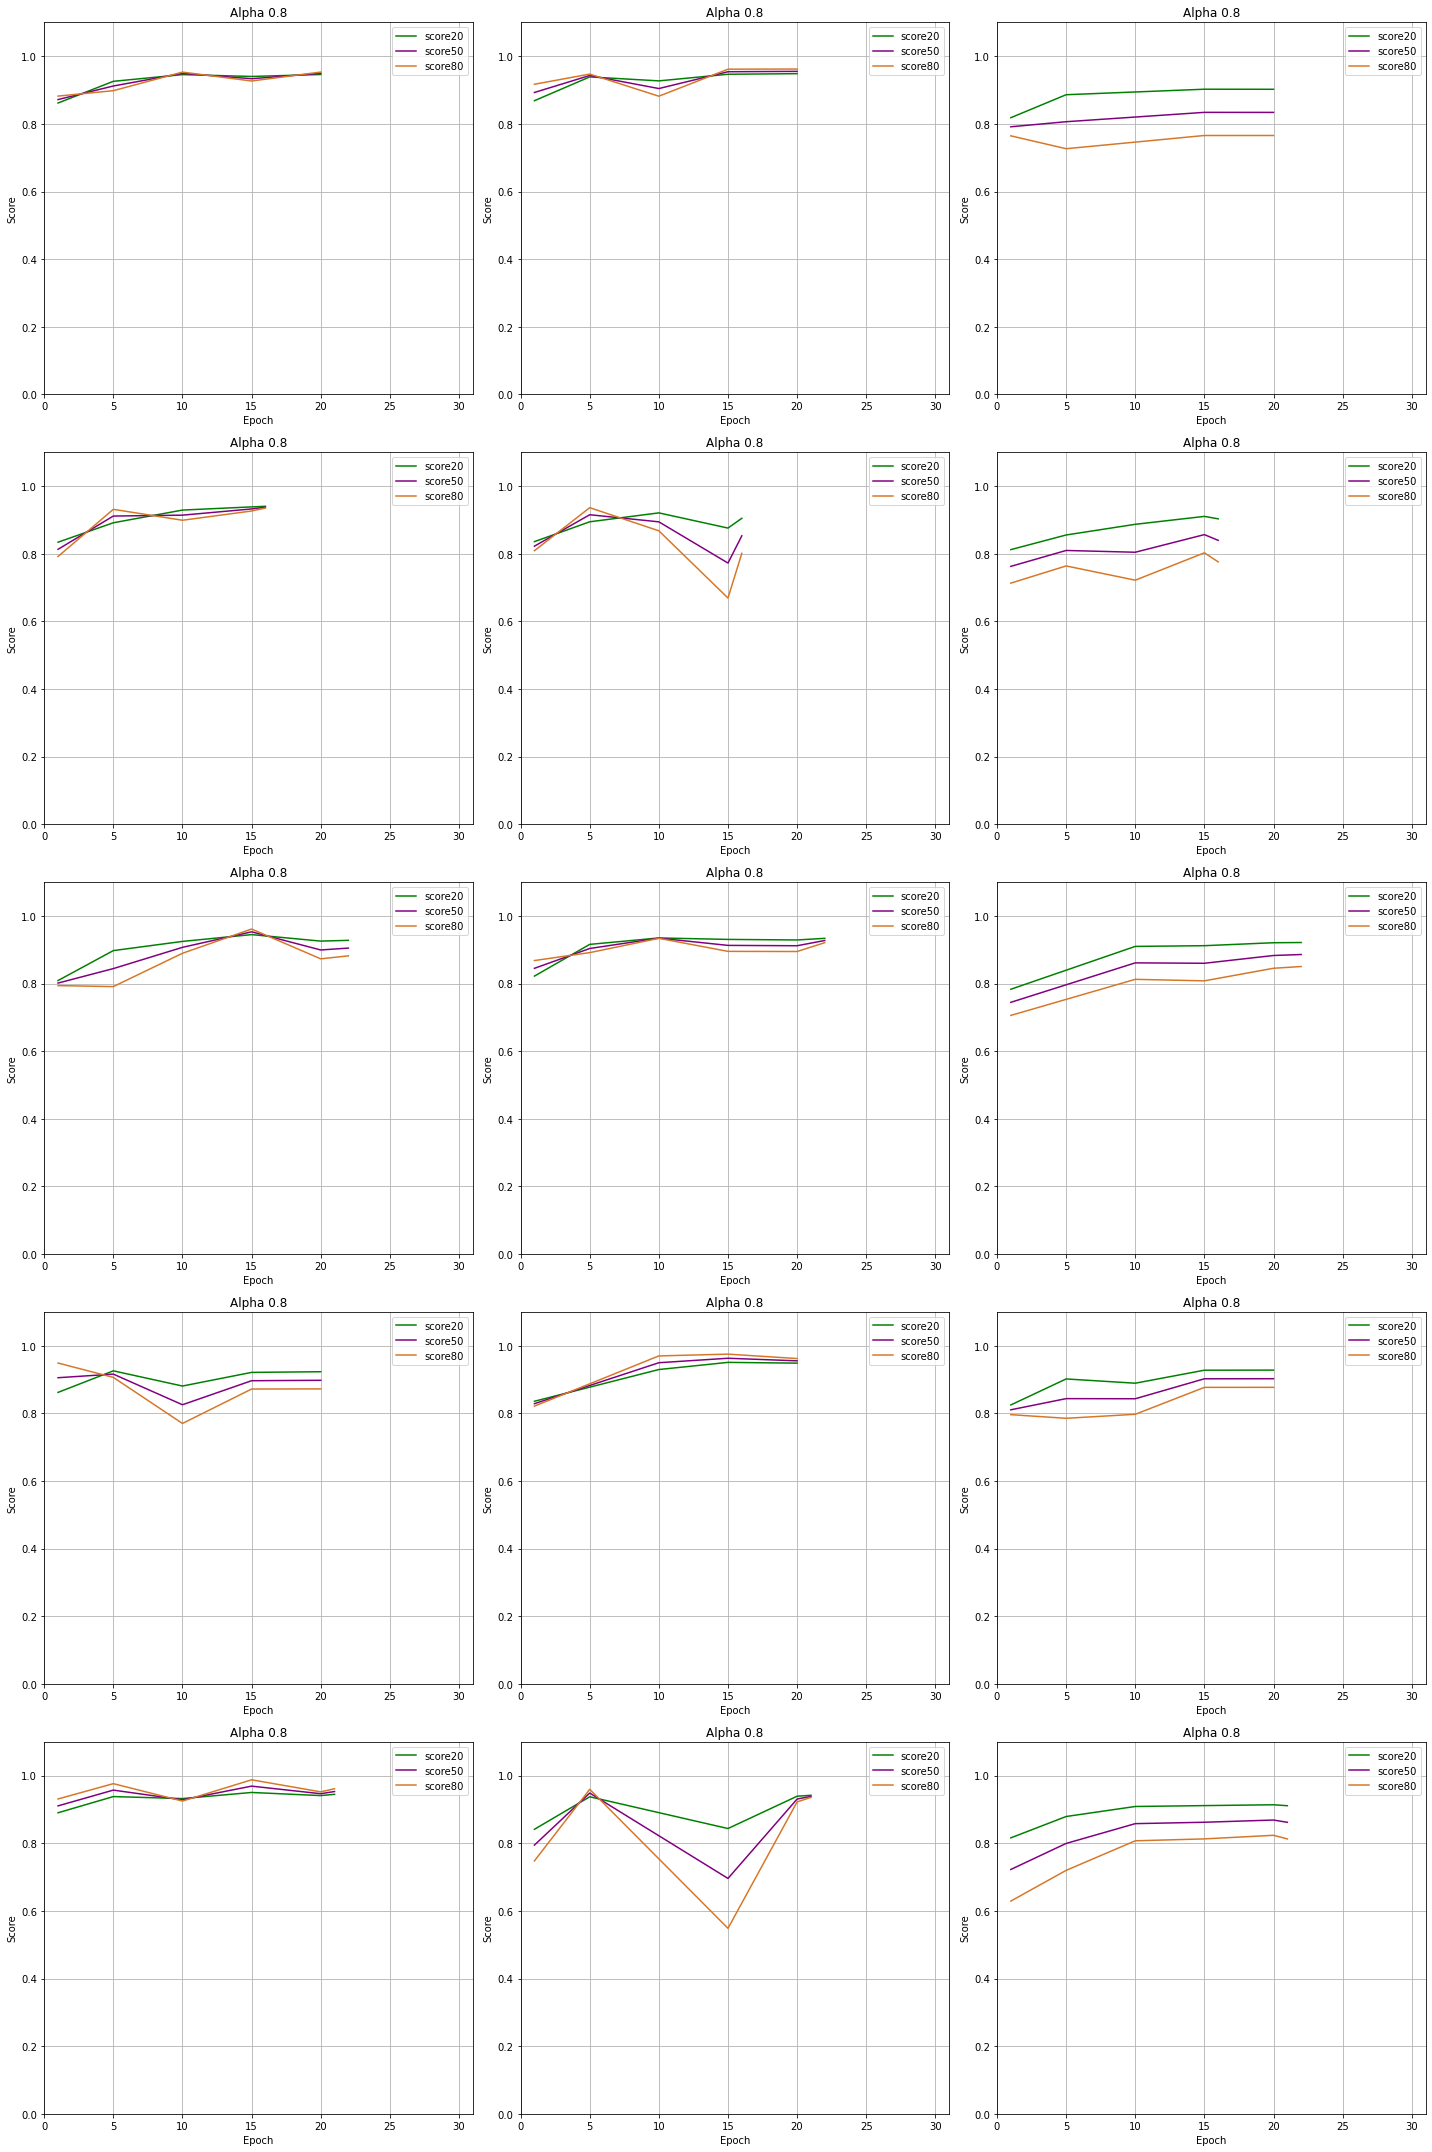

In [8]:
colors = {10:'red', 20:'green', 30:'blue', 40:'cyan', 50:'purple', 60:'orange' , 70:'#d62728', 80:'#d67728', 90:'#e62728',100:'#d61228'}
epochs = [key for key in colors.keys()]
col = [val for k,val in colors.items()]

rep_classes = [20., 27., 30.]
scores = [20,50,80]

fig, ax = plt.subplots(5,3,figsize=(20,30))

for i in df['run'].unique()[1:]:
    print(f'-------------------- run {i} -----------------------------')
    for j, rep_cls in enumerate(rep_classes):
        for score in scores:
            print(f'Score: {score}--------------------------')
            print(f'Class {rep_cls}:')
            base_table = df[df['repaired']==False][df['more_finetune']==False][df['run']==run]
            rep_table = df[df['repaired']==True][df['run']==i][df['rep_cls'] == rep_cls]

            ax[i-1][j].plot(rep_table.sort_values('epoch_ep')['epoch_ep'].unique()\
                                        ,rep_table.sort_values('epoch_ep')[f'common_metric_{score}_cls{int(rep_cls)}'], c=colors[score], label=f'score{score}')

            print(list(rep_table.sort_values('epoch_ep')[f'common_metric_{score}_cls{int(rep_cls)}']))

            ax[i-1][j].legend(loc="best")
            ax[i-1][j].grid(True)
            ax[i-1][j].set_xlim(0,31.0)
            ax[i-1][j].set_ylim(0,1.1)
            ax[i-1][j].set_xlabel('Epoch')
            ax[i-1][j].set_ylabel(f'Score')
            ax[i-1][j].set_title(f'Alpha {score*0.01:.1f}')

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
fig.tight_layout()
plt.show()